<a href="https://colab.research.google.com/github/fedorgrab/garbage-classification/blob/master/garbage_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EAI6000 capstone project

Group members: \
Fedor Grab \
Salman Rafiullah \
Jing Lou

## Goal:
Classify which type of garbage is provided on the image. This is an image recognition task

Publicy available [dataset](https://www.kaggle.com/asdasdasasdas/garbage-classification)

It consists of 6 different classes of garbage: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127). Summary 2467 images.


To solve this task it is a good idea to use [Transfer Learning (TL)](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/). TL is a technique when already developed and trained models for a one type of classification problem are used to solve different classification problem. 

Three of the most popular models are as follows:

* VGG (e.g. [VGG16](https://www.kaggle.com/keras/vgg16) or [VGG19](https://www.kaggle.com/keras/vgg19)).
* GoogLeNet (e.g. [InceptionV3](https://software.intel.com/en-us/articles/inception-v3-deep-convolutional-architecture-for-classifying-acute-myeloidlymphoblastic)).
* Residual Network (e.g. [ResNet50](https://www.kaggle.com/keras/resnet50)).

## Plan:
1. Load dataset of garbage images 
2. Prepare data:
    * Change the input shapes of data to be consistent
    * Normilize it
    * Prepare classification labels array
    * Split data on train and split sets

2. Implement a few different models and try to fit model to it
4. Choose the best model
5. Classify test data and count model accuracy
6. Summarize the work with some insights, explain how it is could be implemented in a real-world problem

By the end of the project we expect a Neural Network model classifying a garbage to one of the 6 given above garbage type with accuracy more than 90%. It can be a complicated challenge due to the fact that provided dataset seems to be difficult to classify. Also number of images

In [0]:
# !pip install -U -q kaggle
# !mkdir -p ~/.kaggle

In [0]:
LOAD_FILES_FROM_DRIVE = True

In [3]:
from contextlib import suppress

with suppress(Exception):
  %tensorflow_version 2.x
from tensorflow import keras
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [4]:
from google.colab import drive


drive.mount('/content/drive')
plt.style.use("seaborn")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !kaggle datasets download -d "andreasantoro/split-garbage-dataset" -p "/content/drive/My Drive" --force
# !unzip "/content/drive/My Drive/split-garbage-dataset.zip"

In [0]:
DATASET_DIR = "/content/drive/My Drive/split-garbage-dataset"

TRAIN_DIR = f"{DATASET_DIR}/train"
TEST_DIR = f"{DATASET_DIR}/test"
VALID_DIR = f"{DATASET_DIR}/valid"

In [0]:
LABELS = ["trash", "plastic", "paper", "metal", "glass", "cardboard"]

LABELS_NUMBERS_MAP = {k:v for k,v in zip(LABELS, range(len(LABELS)))}
LABELS_NUMBERS_REVERSE ={v: k for k, v in LABELS_NUMBERS_MAP.items()}

In [0]:
import numpy as np
from skimage.io import imread_collection


if not LOAD_FILES_FROM_DRIVE:
    for path in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
        image_list = [
            imread_collection(f"{path}/{label}/*.jpg") for label in LABELS
        ]
        X_tmp = np.concatenate(image_list)
        y_tmp = np.concatenate([
            np.full(len(arr), i) for i, arr in enumerate(image_list)
        ])
        data_type = path.split("/")[-1]
        np.save(f"X_{data_type}.npy", X_tmp)
        np.save(f"y_{data_type}.npy", y_tmp)

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_valid = np.load("X_valid.npy")
y_valid = np.load("y_valid.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [0]:
import matplotlib.pyplot as plt


def plot_images(X, y, grayscale=False, label_num_map=None):
    fig, axes = plt.subplots(1, len(X),  figsize=(20, 10))
    if grayscale:
        X_process = X.reshape(len(X_train), 384, 512) / 255
    else:
        X_process = X

    [ax.imshow(X_process[n]) for n, ax in enumerate(axes)]
    if not label_num_map:
        [ax.set_title((y[n])) for n, ax in enumerate(axes)]
    else:
        [ax.set_title((label_num_map[y[n]])) for n, ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]

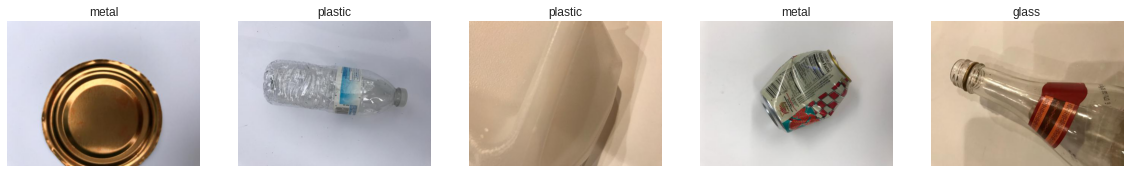

In [10]:
random_indexes = np.random.randint(0, len(X_train), 5)
plot_images(
    X=X_train[random_indexes], 
    y=y_train[random_indexes],
    label_num_map=LABELS_NUMBERS_REVERSE
)

In [0]:
import pandas as pd


y_train_series = pd.Series(y_train)

In [12]:
X_train.shape

(1767, 384, 512, 3)

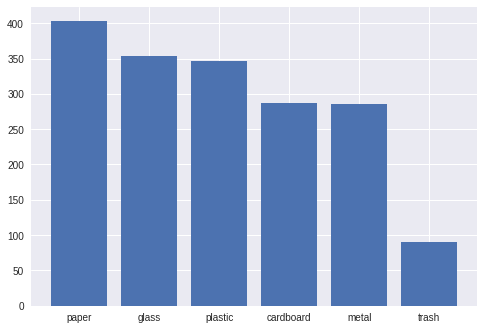

In [13]:
dist = y_train_series.value_counts()
labels = [LABELS[i] for i in dist.index]
plt.bar(labels, dist)
plt.show()

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
 

model = models.Sequential([
    layers.Convolution2D(
        filters=16, 
        input_shape=(384, 512, 3),
        kernel_size=(4, 4), 
        padding="same",
        activation="relu"
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Convolution2D(
        filters=32, 
        kernel_size=(4, 4),
        padding="same",
        activation="relu"
    ),
    layers.MaxPooling2D(input_shape=(2, 2)),
    layers.Convolution2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu"
    ),
    layers.Flatten(),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=len(LABELS), activation="softmax")

])
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [0]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=600,
    validation_data=(X_valid, y_valid)
)

Train on 1767 samples, validate on 250 samples
Epoch 1/20


Could not train the model as it used all available RAM. So I think I should try to increase it. 

Maybe try to start it on Amazon.